In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image as pil_image
import cv2

import glob

import tensorflow as tf
from tensorflow.python.keras.models import model_from_json
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops


import scipy
from scipy import ndimage
from skimage.measure import label, regionprops

%matplotlib inline

/Users/jun/anaconda/envs/ds/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
K.set_learning_phase(False)

## CAM vs. Grad-CAM


In [3]:
JSON_PATH = "resnet_CAM_new.json"
H5_PATH = "resnet_CAM_new.h5"

In [4]:
def load_model(json_path, h5_path):
    with open(json_path, "r") as f:
        loaded_model_json = f.read()
    
    tl_model = model_from_json(loaded_model_json)
    tl_model.load_weights(h5_path)
    
    return tl_model

In [5]:
## 1. load model
model = load_model(JSON_PATH, H5_PATH)

In [6]:
## 2. image sources
testset = glob.glob('testset/*')

samples = []
class_indices = ['ahn', 'hong', 'moon', 'sim', 'you']

for idx, ci in enumerate(class_indices):
    tmp_dict = {}
    tmp_dict['target'] = ci
    tmp_dict['img_path'] = 'testset/' + ci + '.png'
    tmp_dict['class_idx'] = idx
    samples.append(tmp_dict)

In [7]:
def preprocess_input(img_path):
    img = pil_image.open(img_path).resize((224, 224))
    img_arr = np.asarray(img)[:, :, :3] / 255.
    img_tensor = np.expand_dims(img_arr, 0)
    
    return img_arr, img_tensor

In [8]:
def generate_cam(model, img_path, class_idx):
    
    ## img_path -> preprocessed image tensor
    img_arr, img_tensor = preprocess_input(img_path)
    
    ## preprocessed image tensor -> last_conv_output, predictions
    get_output = K.function([model.layers[0].input], [model.layers[-4].output, model.layers[-1].output])
    [conv_outputs, predictions] = get_output([img_tensor])
    
    conv_outputs = conv_outputs[0, :, :, :]
    class_weights = model.layers[-1].get_weights()[0]
    
    ## generate cam
    cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        cam += w * conv_outputs[:, :, i]
        
    cam /= np.max(cam)
    cam = cv2.resize(cam, (224, 224))
    
    return img_arr, cam, predictions    

In [9]:
# model.summary()

In [10]:
def generate_grad_cam(model, img_path, class_idx):

    ## img_path -> preprocessed image tensor
    img_arr, img_tensor = preprocess_input(img_path)

    ## get the derivative of y^c w.r.t A^k
    y_c = model.layers[-1].output.op.inputs[0][0, class_idx]
#     y_c = model.output[0, class_idx]
    
#     layer_output = model.get_layer('block5_conv3').output
    layer_output = model.layers[-4].output
    
    grads = K.gradients(y_c, layer_output)[0]
    gradient_fn = K.function([model.input], [layer_output, grads, model.layers[-1].output])
    
    conv_output, grad_val, predictions = gradient_fn([img_tensor])
    conv_output, grad_val = conv_output[0], grad_val[0]
    
    weights = np.mean(grad_val, axis=(0, 1))
    cam = np.dot(conv_output, weights)
    
    cam = cv2.resize(cam, (224, 224))
    
    ## Relu
    cam = np.maximum(cam, 0)
    
    cam = cam / cam.max()
    
    return img_arr, cam, predictions

In [11]:
def generate_bbox(img, cam, threshold):
    labeled, nr_objects = ndimage.label(cam > threshold)
    props = regionprops(labeled)
    return props

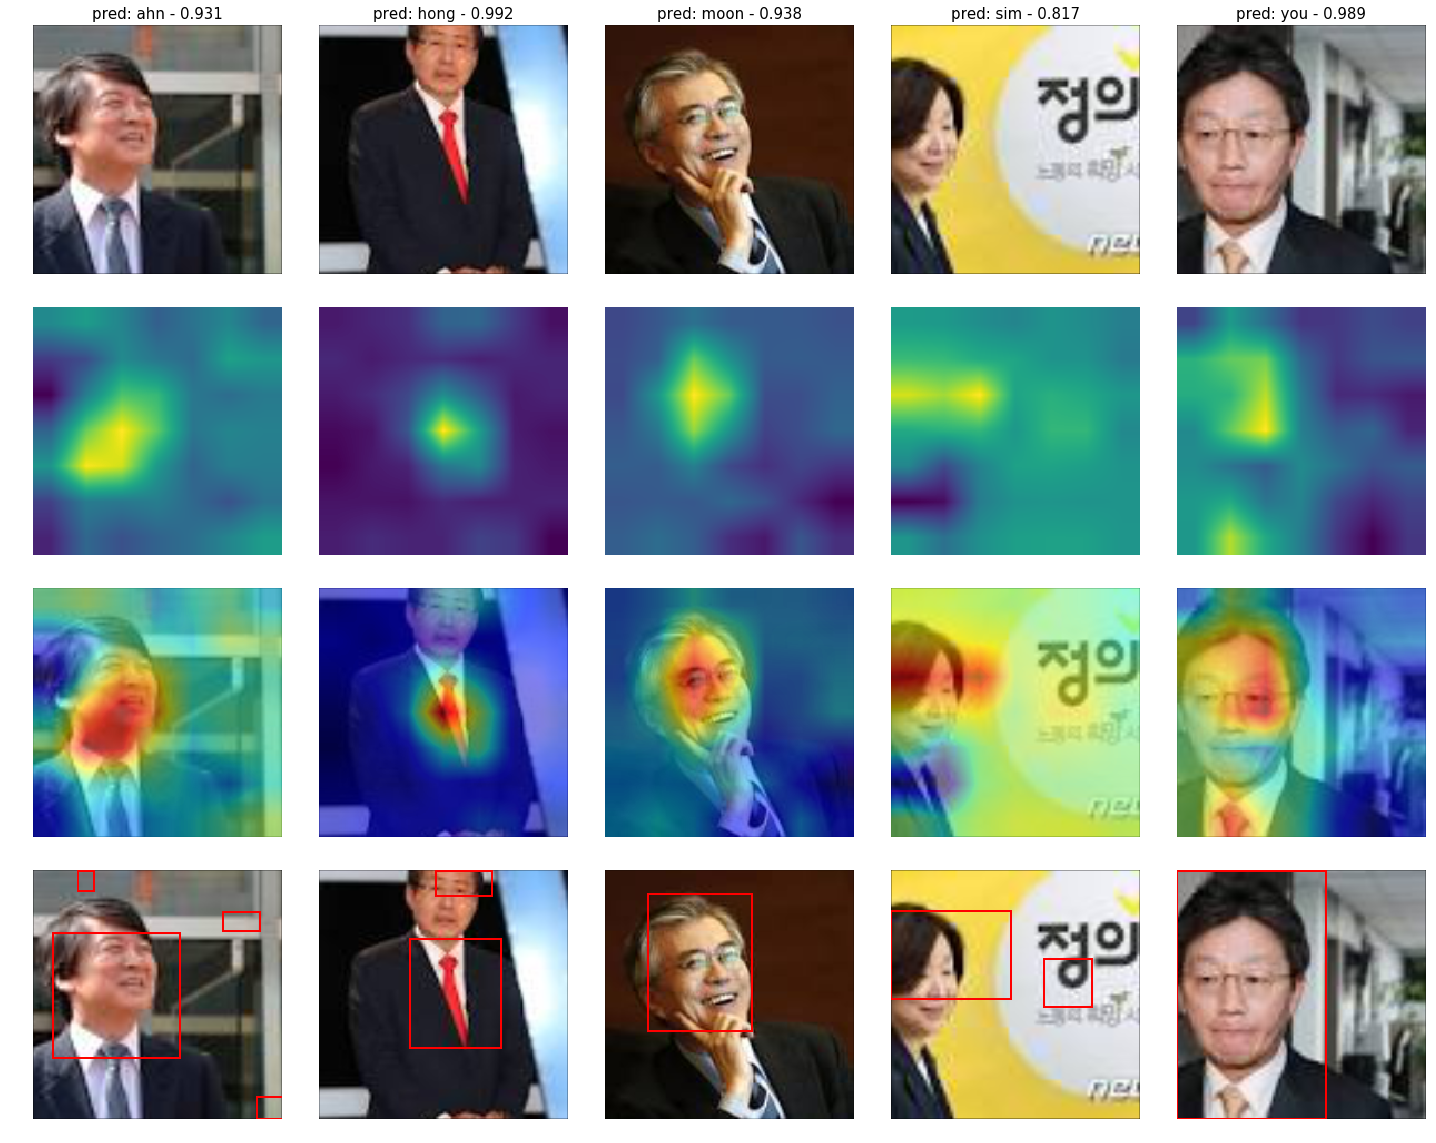

In [12]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for i, s in enumerate(samples):
    img_set = s['target']
    img_path = s['img_path']
    class_idx = s['class_idx']
    img, cam, predictions = generate_cam(model, img_path, class_idx)
    pred_values = np.squeeze(predictions, 0)
    top1 = np.argmax(pred_values)
    top1_value = round(float(pred_values[top1]), 3)
    props = generate_bbox(img, cam, 0.2)
    
    axes[0, i].imshow(img)
    axes[1, i].imshow(cam)
    axes[2, i].imshow(img)
    axes[2, i].imshow(cam, cmap='jet', alpha=0.5)
    
    axes[3, i].imshow(img)
    for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3, i].add_patch(rect)
    
    axes[0,i].axis('off')
    axes[1,i].axis('off')
    axes[2,i].axis('off')
    axes[3,i].axis('off')
    
    axes[0, i].set_title("pred: {} - {}".format(class_indices[top1], top1_value), fontsize=15)
    
plt.tight_layout()
plt.show()

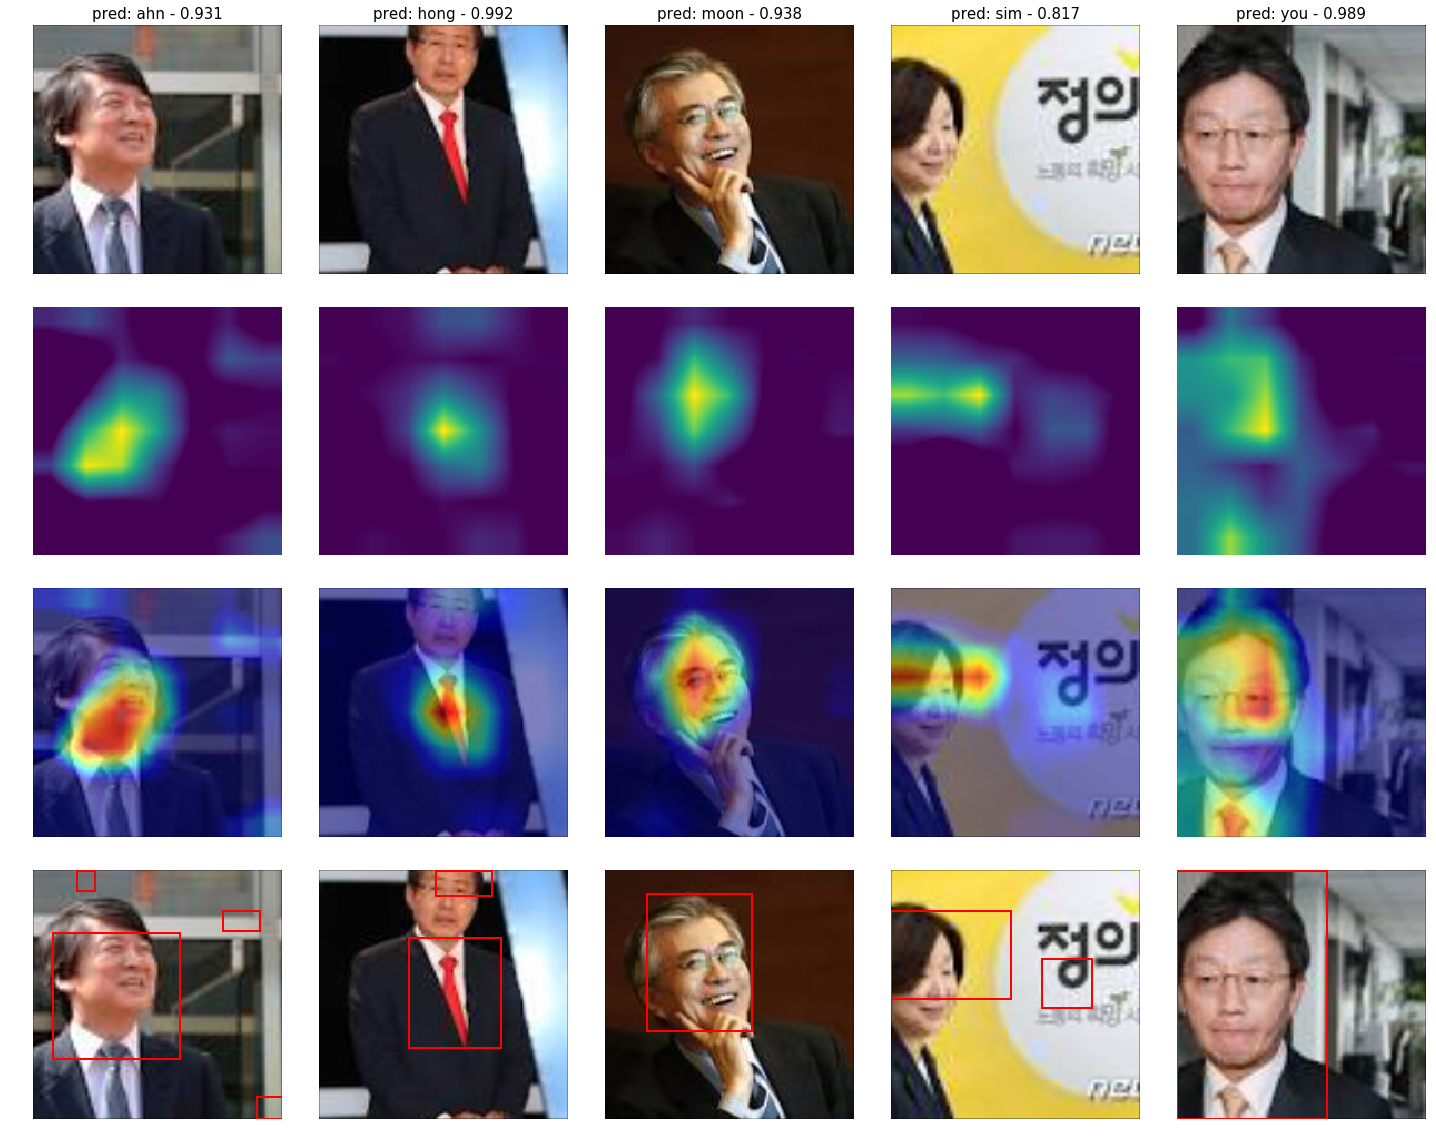

In [13]:
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

for i, s in enumerate(samples):
    img_set = s['target']
    img_path = s['img_path']
    class_idx = s['class_idx']
    img, cam, predictions = generate_grad_cam(model, img_path, class_idx)
    pred_values = np.squeeze(predictions, 0)
    top1 = np.argmax(pred_values)
    top1_value = round(float(pred_values[top1]), 3)
    props = generate_bbox(img, cam, 0.2)
    
    axes[0, i].imshow(img)
    axes[1, i].imshow(cam)
    axes[2, i].imshow(img)
    axes[2, i].imshow(cam, cmap='jet', alpha=0.5)
    
    axes[3, i].imshow(img)
    for b in props:
        bbox = b.bbox
        xs = bbox[1]
        ys = bbox[0]
        w = bbox[3] - bbox[1]
        h = bbox[2] - bbox[0]

        rect = patches.Rectangle((xs, ys), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[3, i].add_patch(rect)
    
    axes[0,i].axis('off')
    axes[1,i].axis('off')
    axes[2,i].axis('off')
    axes[3,i].axis('off')
    
    axes[0, i].set_title("pred: {} - {}".format(class_indices[top1], top1_value), fontsize=15)
    
plt.tight_layout()
plt.show()

In [14]:
def build_guided_model(json_path, h5_path):
    
    if 'GuidedBackProp' not in ops._gradient_registry._registry:
        @ops.RegisterGradient('GuidedBackProp')
        def _GruidedBackProp(op, grad):
            dtype = op.inputs[0].dtype
            return grad * tf.cast(grad > 0., dtype) * tf.cast(op.inputs[0] > 0., dtype)
        
    g = tf.get_default_graph()
    with g.gradient_override_map({'Relu': 'GuidedBackProp'}):
        
        
        new_model = load_model(json_path, h5_path)
        
        return new_model

In [15]:
guided_model = build_guided_model(JSON_PATH, H5_PATH)

In [16]:
def guided_backprop(model, img, activation_layer_idx):
    input_img = model.input
    layer_output = model.layers[activation_layer_idx].output
    grads = K.gradients(layer_output, input_img)[0]
    gradient_fn = K.function([input_img], [grads])
    grads_val = gradient_fn([img])[0]
    return grads_val

def deprocess_image(x):
    x = x.copy()
    if np.ndim(x) > 3:
        x = np.squeeze(x)
    
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    # clip
    x += 0.5
    x = np.clip(x, 0, 1)
    
    ## RGB array
    x *= 255.
    
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [17]:
def generate_guided_grad_cam(guided_model, img_path, grad_cam):
    gb = guided_backprop(guided_model, img=preprocess_input(img_path)[1], activation_layer_idx=-4)
    guided_grad_cam = gb * grad_cam[..., np.newaxis]
    
    return deprocess_image(guided_grad_cam)

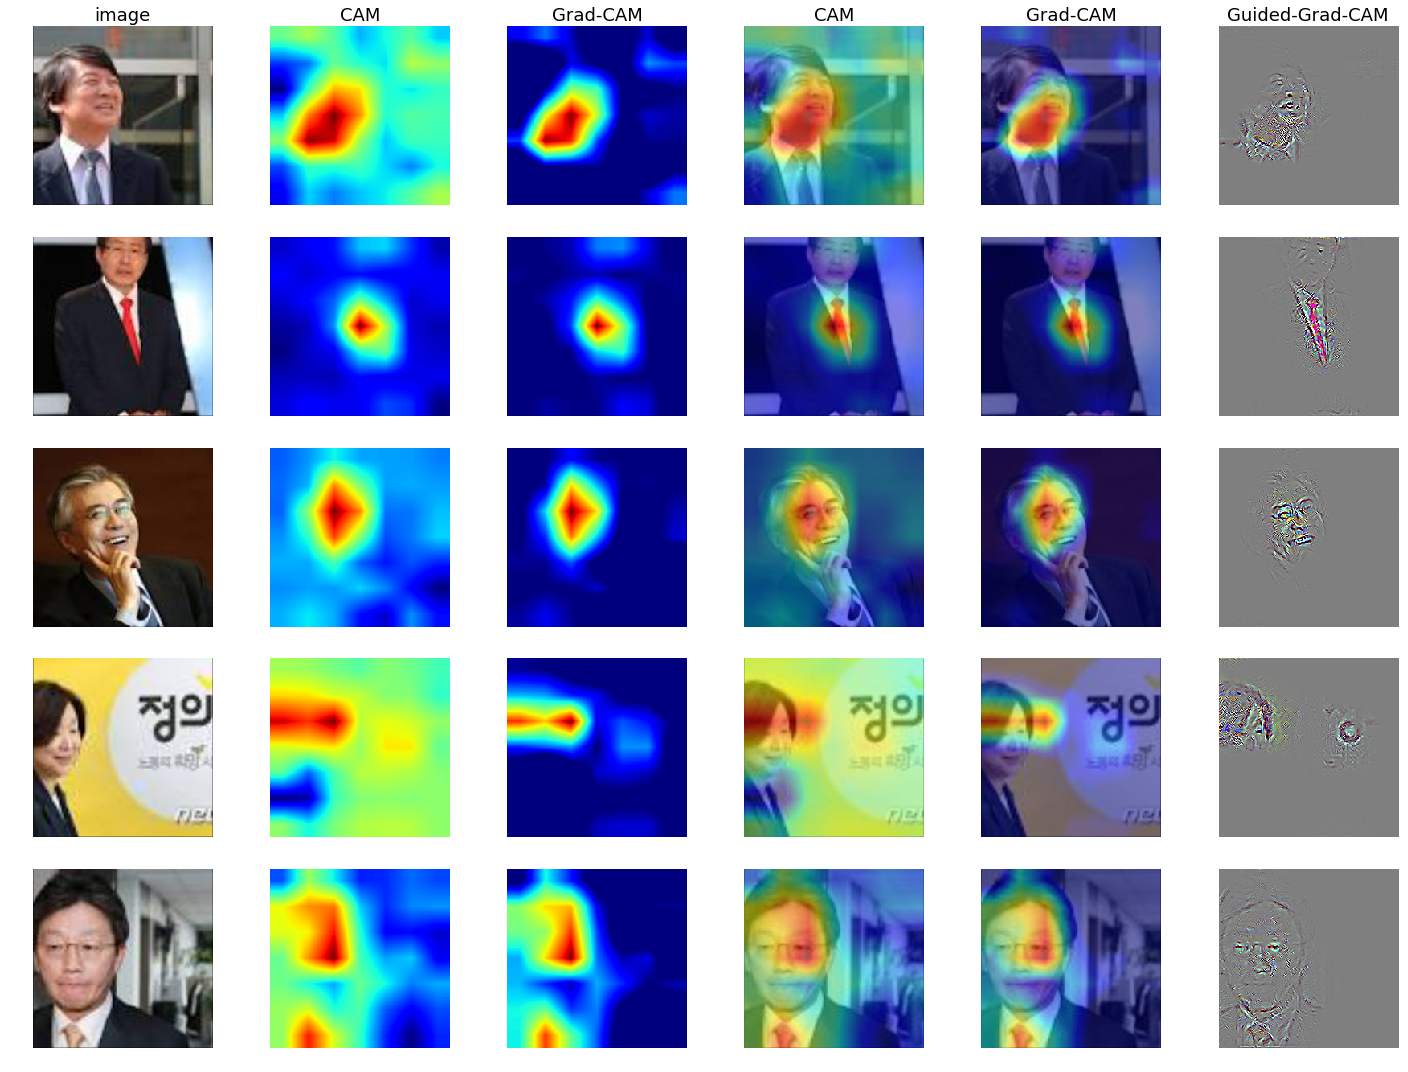

In [18]:
fig, axes = plt.subplots(5, 6, figsize=(20, 15))

for i, s in enumerate(samples):
    img, cam, grad_cam, guided_grad_cam = None, None, None, None
    
    img_set = s['target']
    img_path = s['img_path']
    class_idx = s['class_idx']
    _, cam, _ = generate_cam(model, img_path, class_idx)
    img, grad_cam, predictions = generate_grad_cam(model, img_path, class_idx)
    guided_grad_cam = generate_guided_grad_cam(guided_model, img_path, grad_cam)
    
    axes[i, 0].imshow(img)
    axes[i, 1].imshow(cam, cmap='jet')
    axes[i, 2].imshow(grad_cam, cmap='jet')
    axes[i, 3].imshow(img)
    axes[i, 3].imshow(cam, cmap='jet', alpha=0.5)
    axes[i, 4].imshow(img)
    axes[i, 4].imshow(grad_cam, cmap='jet', alpha=0.5)
    axes[i, 5].imshow(guided_grad_cam)
    
    
    axes[i, 0].axis('off')
    axes[i, 1].axis('off')
    axes[i, 2].axis('off')
    axes[i, 3].axis('off')
    axes[i, 4].axis('off')
    axes[i, 5].axis('off')
    
    axes[0, 0].set_title("image", fontsize=18)
    axes[0, 1].set_title("CAM", fontsize=18)
    axes[0, 2].set_title("Grad-CAM", fontsize=18)
    axes[0, 3].set_title("CAM", fontsize=18)
    axes[0, 4].set_title("Grad-CAM", fontsize=18)
    axes[0, 5].set_title("Guided-Grad-CAM", fontsize=18)
    
plt.tight_layout()
plt.show()